In [1]:
import pickle
#import pandas as pd

from sklearn.metrics import f1_score,accuracy_score,matthews_corrcoef,precision_score,recall_score
from sklearn.metrics import roc_curve,roc_auc_score

import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [2]:
test=pd.read_csv("test.csv")

In [5]:
with open("models/VJgene_logistic_regression.pkl", "rb") as f:
    vj_lr=pickle.load(f)

with open("models/VJgene_xgboost.pkl", "rb") as f:
    vj_xgb=pickle.load(f)

In [8]:
def attach_pred_results(results,df):
    df=df.copy()
    for i in range(10):
        df[f"model_{i}_pred"]=results[i]["test_prob"][:,1]
    return df
vj_lr_test=attach_pred_results(vj_lr,test)
vj_xgb_test=attach_pred_results(vj_xgb,test)

In [10]:
rmsprop_test=pd.read_csv("pred_results/cnn_rmsprop/cnn_rmsprop_pred_result.csv").drop(columns=["Unnamed: 0"])
adam_test=pd.read_csv("pred_results/cnn_adam/cnn_adam_pred_result.csv").drop(columns=["Unnamed: 0"])
conv1_test=pd.read_csv("pred_results/cnn_adam_conv1/cnn_adam_conv1_pred_result.csv").drop(columns=["Unnamed: 0"])
resnet_test=pd.read_csv("pred_results/cnn_adam_resnet/cnn_adam_resnet_pred_result.csv").drop(columns=["Unnamed: 0"])
esm_featurizer_test=pd.read_csv("pred_results/esm_featurizer/full_seq_pred_result.csv").drop(columns=["Unnamed: 0"])
abta2_featurizer_test=pd.read_csv("pred_results/abta2_featurizer/test_df_eval.csv").drop(columns=["Unnamed: 0"])

with open("pred_results/esm_finetuned_kfold/pos_pair_possibility.pkl","rb") as f:
    esm_pred=pickle.load(f)
with open("pred_results/immunomatch_kfold/pos_pair_possibility.pkl","rb") as f:
    abta2_pred=pickle.load(f)
    
esm_test=test.copy()
abta2_test=test.copy()

for i in range(10):
    abta2_test[f"model_{i}_pred"]=abta2_pred[i]
    esm_test[f"model_{i}_pred"]=esm_pred[i]

In [12]:
def get_mean_pred (df):
    mean_pred=np.mean(df.loc[:,['model_0_pred', 'model_1_pred', 'model_2_pred',
       'model_3_pred', 'model_4_pred', 'model_5_pred', 'model_6_pred',
       'model_7_pred', 'model_8_pred', 'model_9_pred']].values,axis=1)
    return mean_pred



def cal_all_folds_metrics (metrics,eval_df):
    eval_metrics={}
    for model,results in eval_df.items():
        eval_metrics[model]={}
        labels=np.array(results["label"])
        for i in range(10):
            pred=np.array(results[f"model_{i}_pred"])
            this_eval_metric=metrics(labels,[int(i) for i in (pred>0.5)])
            eval_metrics[model][i]=this_eval_metric
    
    eval_metrics_df=pd.DataFrame(eval_metrics).T
    # melt the dataframe
    metrics_name=metrics.__name__.split("_")[0]
    eval_metrics_df=eval_metrics_df.reset_index().melt(id_vars="index",var_name="fold",value_name=metrics_name).rename(columns={"index":"model"})
    return eval_metrics_df 

eval_df={"VJgene_lr":vj_lr_test,"VJgene_xgb":vj_xgb_test,"rmsprop":rmsprop_test,"adam":adam_test,"conv1":conv1_test,"resnet":resnet_test,"esm_featurizer":esm_featurizer_test,"abta2_featurizer":abta2_featurizer_test,"esm":esm_test,"abta2":abta2_test} 

catogory={"VJgene_lr":"Gene usage","VJgene_xgb":"Gene usage","rmsprop":"CDR3, CNN","adam":"CDR3, CNN","conv1":"CDR3, CNN","resnet":"CDR3, CNN","ablang_featurizer":"V seqs, featurizer LLM","abty_featurizer":"V seqs, featurizer LLM","abta2_featurizer":"V seqs, featurizer LLM","esm_featurizer":"V seqs, featurizer LLM","esm":"V seqs, fine-tune LLM","abta2":"V seqs, fine-tune LLM"}

In [15]:
all_accs=cal_all_folds_metrics(accuracy_score,eval_df)
all_accs["catogory"]=all_accs["model"].map(catogory)
all_accs

,model,fold,accuracy,catogory
0,VJgene_lr,0,0.498461,Gene usage
1,VJgene_xgb,0,0.515863,Gene usage
2,rmsprop,0,0.571917,"CDR3, CNN"
3,adam,0,0.586668,"CDR3, CNN"
4,conv1,0,0.588507,"CDR3, CNN"
...,...,...,...,...
95,resnet,9,0.596331,"CDR3, CNN"
96,esm_featurizer,9,0.499147,"V seqs, featurizer LLM"
97,abta2_featurizer,9,0.583846,"V seqs, featurizer LLM"
98,esm,9,0.567855,"V seqs, fine-tune LLM"


/tmp/ipykernel_3236124/3250290363.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


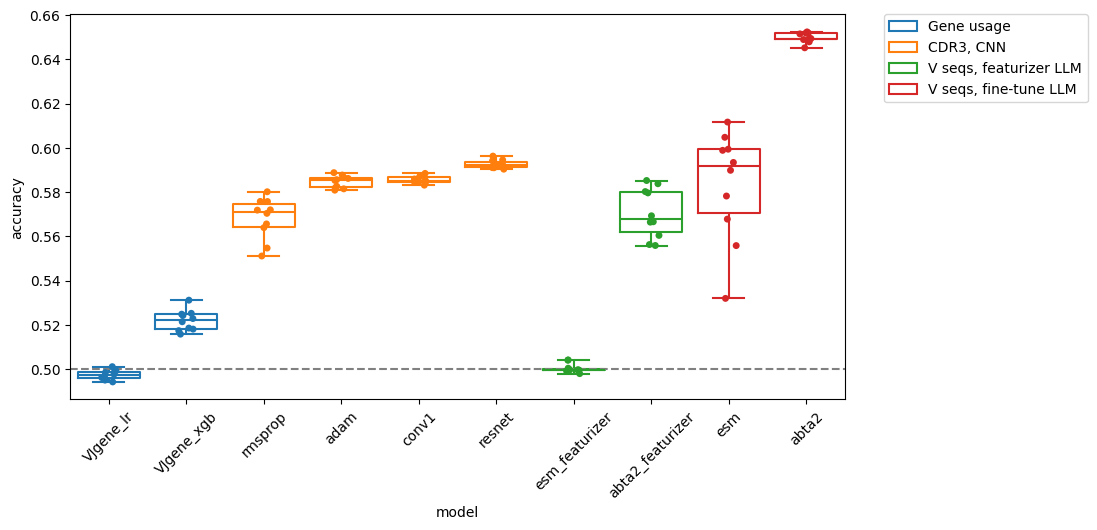

In [17]:
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=all_accs,x="model",y="accuracy",fill=False,ax=ax,whis=(0, 100),hue="catogory")
ax.axhline(y=0.5, linestyle='--',color='grey')
sns.stripplot(data=all_accs,x="model",y="accuracy",ax=ax,hue="catogory",legend=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig("all_models_accuracy.svg",bbox_inches="tight")